In [36]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Resize
from torchvision.io import read_image
from skimage import io, transform
from torchvision import transforms, utils
import numpy as np

df_cards = pd.read_csv('dataset/train_labels.csv')

class PlayingCardDataset(Dataset):
    """Playing card dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            resize_shape (tuple, optional): Desired shape of the image.
        """
        self.playing_cards = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.playing_cards)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.playing_cards.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.playing_cards.iloc[idx, 3]
        sample = {"image": image, "label": label}

        if self.transform:
            image = self.transform(sample)

        return sample
    


In [30]:
train_dataset = PlayingCardDataset(csv_file='dataset/train_labels.csv', root_dir='dataset/train/')

0 (1200, 750, 3) ace of hearts
1 (275, 183, 3) three of diamonds
2 (470, 281, 3) jack of hearts
3 (247, 204, 3) seven of spades


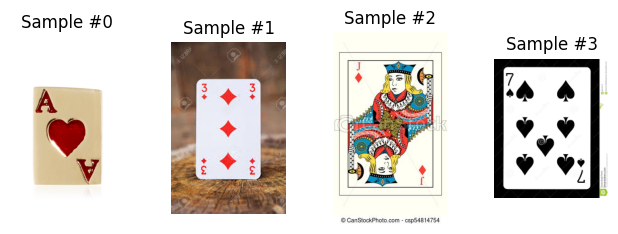

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i, sample in enumerate(train_dataset):
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

In [34]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image)}

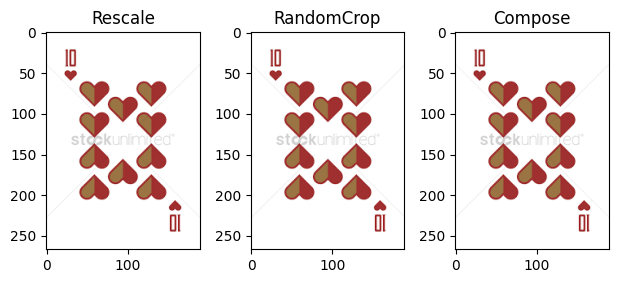

In [38]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[10]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(sample['image'])

plt.show()